In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import igraph as ig
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


In [2]:
dataset = pd.read_csv(r"C:\Users\yangs\Desktop\games_rm_1v1_s5.csv").drop(columns = "Unnamed: 0")
df = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server", "mmr_0", "mmr_1"]].dropna(axis= 0)
df["started_at"] = pd.to_datetime(df["started_at"])

df = df.assign(period = np.where(df["started_at"].between("2023-06-16", "2023-8-16"), 0, 1))
df = df.drop(columns = "started_at")

p1 = df.loc[:,["player_0", "mmr_0", "period"]].rename(columns = {"player_0": "Player_ID", "mmr_0": "MMR"})
p2 = df.loc[:, ["player_1", "mmr_1", "period"]].rename(columns = {"player_1": "Player_ID", "mmr_1": "MMR"})


In [3]:
player = pd.concat([p1, p2]).groupby(["Player_ID", "period"]).agg(Mean_MMR = ("MMR", "mean"), Game_Count = ("MMR", "count")).reset_index()
player = player.pivot(index = "Player_ID", columns = "period", values = ["Mean_MMR", "Game_Count"]).dropna(axis = 0)
player = player[(player["Game_Count"][0] > 10) & (player["Game_Count"][1] > 10)]

In [4]:
group_0 = player[player["Mean_MMR"][0].between(700, 950)].copy()
group_1 = player[player["Mean_MMR"][0].between(950, 1200)].copy()

group_0["Group"] = 0
group_1["Group"] = 1

selected_players = pd.concat([group_0, group_1]).reset_index()
selected_players["MMR_diff"] = selected_players["Mean_MMR"][1] - selected_players["Mean_MMR"][0]
selected_player_ID = selected_players["Player_ID"].tolist()


player_group_membership = selected_players.loc[:, [("Player_ID", ""), ("Group", ""), ("MMR_diff", ""), ("Mean_MMR", 0)]]
player_group_membership.columns = player_group_membership.columns.get_level_values(0)
player_group_membership = player_group_membership.drop_duplicates(subset="Player_ID")

player_group_membership = player_group_membership.assign(trend_group = np.where(player_group_membership["MMR_diff"] < 0, 0, 1))

pgm = player_group_membership
player_group_membership = pgm[((pgm["trend_group"] == 0) & (pgm["Group"] == 0)) | ((pgm["trend_group"] == 1) & (pgm["Group"] == 1))].drop(columns = ["MMR_diff", "trend_group"])
selected_player_ID = player_group_membership["Player_ID"].tolist()

In [5]:
df_0 = df[df["period"] == 0].copy()
df_1 = df[df["period"] == 1].copy()

edge_0 = df_0[df_0["player_0"].isin(selected_player_ID) & df_0["player_1"].isin(selected_player_ID)].loc[:, ["player_0", "player_1"]].drop_duplicates()
edge_1 = df_1[df_1["player_0"].isin(selected_player_ID) & df_1["player_1"].isin(selected_player_ID)].loc[:, ["player_0", "player_1"]].drop_duplicates()

In [6]:
# Find the common nodes
nodes_0 = set(edge_0["player_0"]).union(set(edge_0["player_1"]))
nodes_1 = set(edge_1["player_0"]).union(set(edge_1["player_1"]))
common_nodes = nodes_0.intersection(nodes_1)

# 2. Map common nodes to a common set of consecutive integers
node_mapping = {node: idx for idx, node in enumerate(common_nodes)}
pd_node_mapping = pd.DataFrame.from_dict(node_mapping, orient = "index")
pd_node_mapping = pd_node_mapping.reset_index()
pd_node_mapping.rename(columns = {"index": "Player_ID", 0: "node_id"}, inplace = True)

# Function to remap edges
def remap_edges(edge_df, mapping):
    edge_df_remapped = edge_df[edge_df["player_0"].isin(mapping) & edge_df["player_1"].isin(mapping)].copy()
    edge_df_remapped["player_0"] = edge_df_remapped["player_0"].map(mapping)
    edge_df_remapped["player_1"] = edge_df_remapped["player_1"].map(mapping)
    return edge_df_remapped

# 3. Create sub-networks based on the intersection
sub_network_0 = remap_edges(edge_0, node_mapping).values.tolist()
sub_network_1 = remap_edges(edge_1, node_mapping).values.tolist()

In [7]:
g_0 = ig.Graph(edges = sub_network_0, directed = False)
g_1 = ig.Graph(edges = sub_network_1, directed = False)

g_0.simplify(multiple=True, loops=False)
g_1.simplify(multiple=True, loops=False)

A0 = torch.Tensor(g_0.get_adjacency().data)
A1 = torch.Tensor(g_1.get_adjacency().data)

In [8]:
permutation = pd.merge(pd_node_mapping, player_group_membership).sort_values(by = "Mean_MMR")["node_id"].to_numpy().tolist()

Ap0 = A0[np.ix_(permutation, permutation)]
Ap1 = A1[np.ix_(permutation, permutation)]

<Axes: >

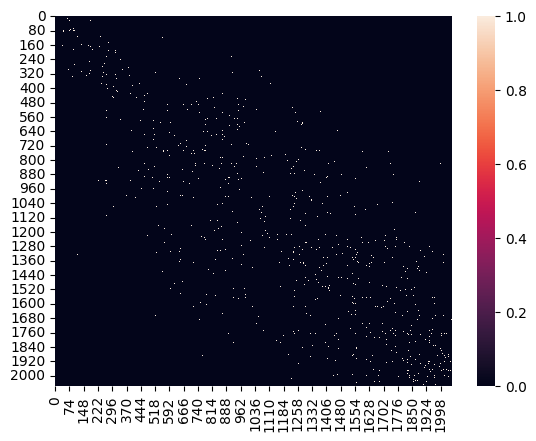

In [9]:
sns.heatmap(Ap0)

Text(0, 0.5, 'SV')

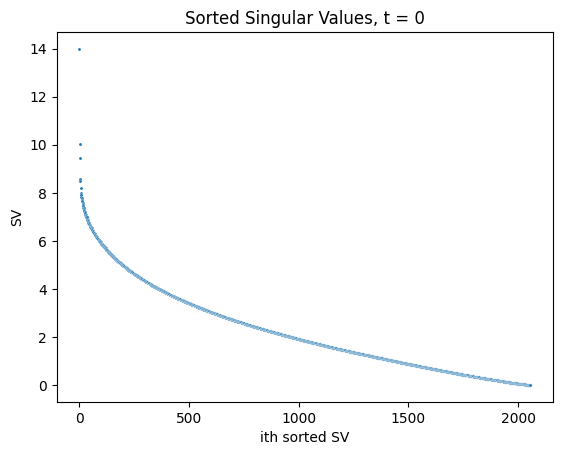

In [10]:
A0_svd = torch.svd(Ap0)
sns.scatterplot(x = list(range(len(A0_svd[1]))), y = A0_svd[1], s = 5)
# Add title and axis labels
plt.title('Sorted Singular Values, t = 0')
plt.xlabel('ith sorted SV')
plt.ylabel('SV')

<Axes: >

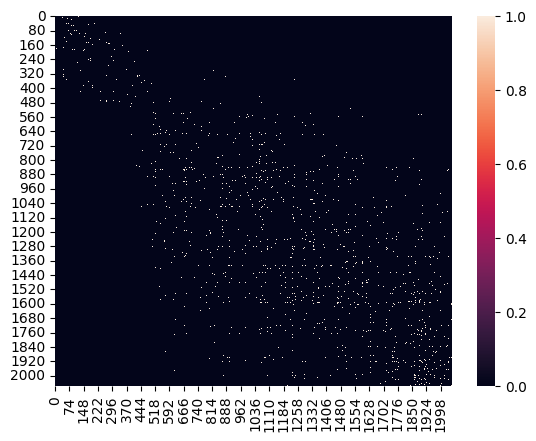

In [11]:
sns.heatmap(Ap1)

Text(0, 0.5, 'SV')

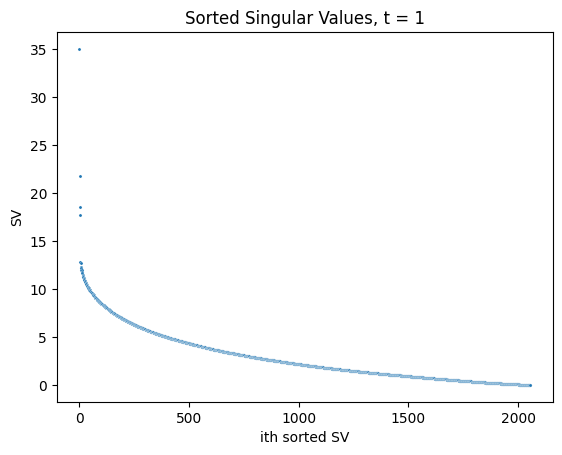

In [12]:
A1_svd = torch.svd(Ap1)
sns.scatterplot(x = list(range(len(A1_svd[1]))), y = A1_svd[1], s = 5)
# Add title and axis labels
plt.title('Sorted Singular Values, t = 1')
plt.xlabel('ith sorted SV')
plt.ylabel('SV')

<Axes: xlabel='0', ylabel='1'>

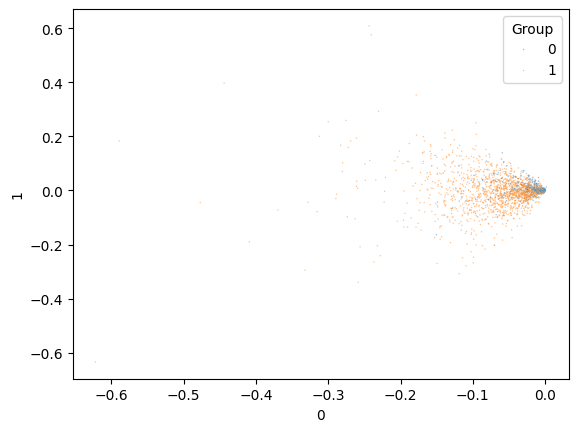

In [13]:
p = 2

init_0 = Align.Oracle.ASE(A0, p)
init_1 = Align.Oracle.ASE(A1, p)

pd_init_0 = pd.DataFrame(init_0.detach().numpy())
pd_init_1 = pd.DataFrame(init_1.detach().numpy())

pd_init_0["index"] = pd_init_0.index
pd_init_0 = pd.merge(pd_init_0, pd_node_mapping, how = "left", left_on = "index", right_on = "node_id").drop(columns = ["index", "node_id"])
pd_init_0 = pd.merge(pd_init_0, player_group_membership, how = "left")

pd_init_1["index"] = pd_init_1.index
pd_init_1 = pd.merge(pd_init_1, pd_node_mapping, how = "left", left_on = "index", right_on = "node_id").drop(columns = ["index", "node_id"])
pd_init_1 = pd.merge(pd_init_1, player_group_membership, how = "left")


sns.scatterplot(pd_init_0, x = 0, y = 1, s = 1, alpha = 0.5, hue = "Group")


<Axes: xlabel='0', ylabel='1'>

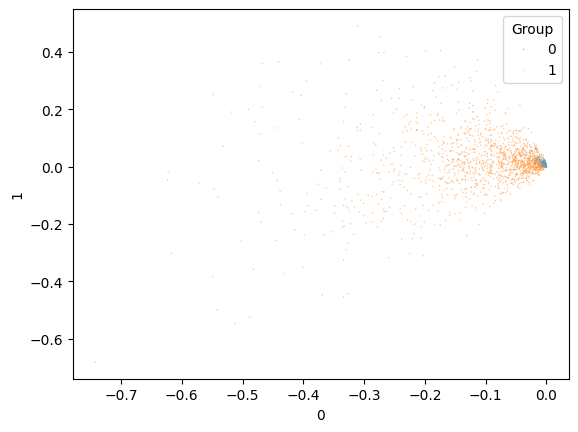

In [14]:
sns.scatterplot(pd_init_1, x = 0, y = 1, s = 1, alpha = 0.5, hue = "Group")

In [15]:
fit_lat_pos_0 = Align.GD_RDPG(A0, 50, init_0, smoothing = 1000, tol = 1e-1, verbose = True)

prev_lp = fit_lat_pos_0.fitted.clone().detach().to(device)

fit_lat_pos_1 = Align.GD_RDPG(A1, 50, prev_lp, smoothing = 1000, tol = 1e-1, verbose = True)

Epoch 100, Align Loss: 17161.17578125, simplex Loss: 0.5158699750900269
Epoch 200, Align Loss: 17124.615234375, simplex Loss: 0.6335268616676331
Epoch 300, Align Loss: 17108.220703125, simplex Loss: 0.5935218930244446
Epoch 400, Align Loss: 17102.0234375, simplex Loss: 0.5553844571113586
Epoch 500, Align Loss: 17099.880859375, simplex Loss: 0.5582336783409119
Epoch 600, Align Loss: 17099.326171875, simplex Loss: 0.5565080642700195
Epoch 700, Align Loss: 17099.197265625, simplex Loss: 0.5523220300674438
Epoch 800, Align Loss: 17099.173828125, simplex Loss: 0.5507317185401917
Epoch 900, Align Loss: 17099.173828125, simplex Loss: 0.549826979637146
Epoch 1000, Align Loss: 17099.173828125, simplex Loss: 0.5493871569633484
Epoch 1100, Align Loss: 17099.173828125, simplex Loss: 0.5505170822143555
Epoch 1200, Align Loss: 17099.173828125, simplex Loss: 0.5479882955551147
Epoch 1300, Align Loss: 17099.173828125, simplex Loss: 0.5493906736373901
Epoch 1400, Align Loss: 17099.173828125, simplex Lo

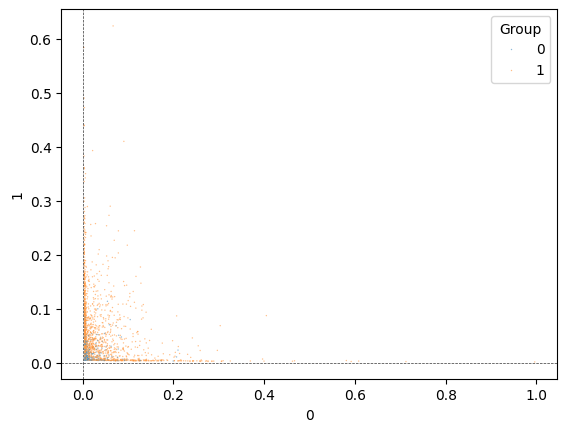

In [16]:
pd_fit_0 = pd.DataFrame(fit_lat_pos_0.fitted.cpu().detach().numpy())

pd_fit_0["index"] = pd_fit_0.index
pd_fit_0 = pd.merge(pd_fit_0, pd_node_mapping, how = "left", left_on = "index", right_on = "node_id").drop(columns = ["index", "node_id"])
pd_fit_0 = pd.merge(pd_fit_0, player_group_membership, how = "left")

sns.scatterplot(pd_fit_0, x = 0, y = 1, s = 1, alpha = 0.5, hue = "Group")
# Add the lines
plt.axvline(x=0, color='black', linestyle='--', label='x = 0', linewidth = 0.5, alpha = 0.8)
plt.axhline(y=0, color='black', linestyle='--', label='y = 0', linewidth = 0.5, alpha = 0.8)

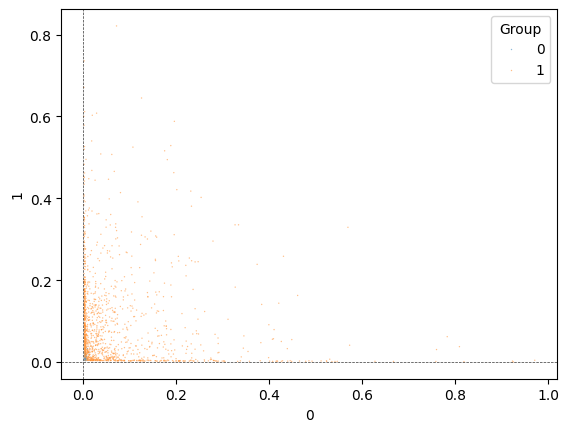

In [17]:
pd_fit_1 = pd.DataFrame(fit_lat_pos_1.fitted.cpu().detach().numpy())

pd_fit_1["index"] = pd_fit_1.index
pd_fit_1 = pd.merge(pd_fit_1, pd_node_mapping, how = "left", left_on = "index", right_on = "node_id").drop(columns = ["index", "node_id"])
pd_fit_1 = pd.merge(pd_fit_1, player_group_membership, how = "left")

sns.scatterplot(pd_fit_1, x = 0, y = 1, s = 1, alpha = 0.5, hue = "Group")
# Add the lines
plt.axvline(x=0, color='black', linestyle='--', label='x = 0', linewidth = 0.5, alpha = 0.8)
plt.axhline(y=0, color='black', linestyle='--', label='y = 0', linewidth = 0.5, alpha = 0.8)

In [18]:
def gen_X(Y, Z, group_sizes):
    Y = Y.to(device)
    n, p = Z.shape
    
    # Z_s = Z[:, :(p-1)].to(device)
    Z_s = Z.to(device)


    #within-group indicator matrix -- jth element of ith row is 1 IF j and i has the same group membership
    
    
    wthin_g = torch.block_diag(*[torch.ones(i, i) for i in group_sizes]).to(device)
    #between-group indicator matrix       
    btwn_g  = (-1)*(wthin_g - 1)        

    Y1 = (Y * wthin_g)
    Y2 = (Y * btwn_g)

    all_ones = torch.ones(n,1).to(device)

    #take row/col sums of within/between group adjacency matrix -- this will be the scaling factor
    S1 = torch.max(all_ones, torch.sum(Y1, 1, True)).repeat(1, (p-1))       
    S2 = torch.max(all_ones, torch.sum(Y2, 1, True)).repeat(1, (p-1))

    A1 = Y1.matmul(Z_s)/S1
    A2 = Y2.matmul(Z_s)/S2

    X = torch.cat((Z_s, A1, A2, all_ones), 1)

    
    X = X.to("cpu")
    del(Z_s, wthin_g, btwn_g, Y1, Y2, all_ones, S1, S2, A1, A2)
    torch.cuda.empty_cache()

    return(X)

In [19]:
combined_fitted_latpos = pd.merge(pd_fit_1.sort_values(by = "Group"), pd_fit_0, how = "inner", on = "Player_ID").drop(columns = "Group_y")
combined_fitted_latpos = combined_fitted_latpos.assign(**{"last_y": 1 - combined_fitted_latpos.filter(regex = "^\d_y").sum(axis = 1)})
group_size_0, group_size_1 = combined_fitted_latpos[combined_fitted_latpos["Group_x"] == 0].shape[0], combined_fitted_latpos[combined_fitted_latpos["Group_x"] == 1].shape[0] 


In [20]:
Z0 = torch.tensor(combined_fitted_latpos.loc[:, ["0_x", "1_x"]].to_numpy(), dtype = torch.float32)
Z1 = torch.tensor(combined_fitted_latpos.loc[:, ["0_y", "1_y", "last_y"]].to_numpy(), dtype = torch.float32)
X0 = gen_X(A0, Z0, [group_size_0, group_size_1])

In [21]:
C = Dir_Reg.fit.gen_constraint(3, True)
result = Dir_Reg.fit(X0, Z1, beta_guess = torch.tensor([1, 1, 1, -30.]))
est = result.est_result["estimate"]
print(f"estimate of \u03B2 is {torch.linalg.solve(C.T @ C, C.T) @ est.reshape(-1)}")

estimate of β is tensor([ 2.2008,  0.9095, -1.5528,  0.5755])


In [22]:
result.est_result["info_lost"]

0.0

In [23]:
LB = est.reshape(-1) - 2*torch.sqrt(torch.diag(torch.linalg.solve(result.est_result["fisher_info"], torch.eye(21))))
UB = est.reshape(-1) + 2*torch.sqrt(torch.diag(torch.linalg.solve(result.est_result["fisher_info"], torch.eye(21))))
pd.DataFrame(torch.cat([LB.unsqueeze(dim = 0), UB.unsqueeze(dim = 0)], dim = 0).T.detach().numpy())

,0,1
0,-0.111960,0.879326
1,-3.452288,-2.543709
2,-4.062386,-3.006570
3,-2.081699,-1.150379
4,2.040125,3.035755
5,-1.615941,-0.578862
6,-0.382071,1.333026
7,0.548862,2.293215
8,-0.465147,1.377769
9,-1.881347,-0.128200


Example from simulation

In [117]:
T, n, alpha_0 = 2, 3000, [[1,1,1], [1,1,1], [1,1,1]]
C = Dir_Reg.fit.gen_constraint(3, True)
model_neg_4 = sim.ABC(time = T,
                    nodes = n,
                    beta = [1, 1, -4, 5],
                    alpha_0 = alpha_0)

Z0, Z1 = model_neg_4.synth_data["lat_pos"]
Y0, Y1 = model_neg_4.synth_data["obs_adj"]

X0 = sim.ABC.gen_X(Y0, Z0, 3)
result = Dir_Reg.fit(X0, Z1)
est = result.est_result["estimate"]

print(f"estimate of \u03B2 is {torch.linalg.solve(C.T @ C, C.T) @ est.reshape(-1)}")

estimate of β is tensor([ 0.9909,  1.0059, -3.9806,  5.0533])


In [130]:
data_loss = []
align_loss = []
simplex_loss = []
for i in [5, 25, 125, 625, 3125]:
    for j in [5, 25, 125, 625, 3125]:
        temp = Align.GD_RDPG(A1, i, init_1, smoothing = j, tol = 1e-1, verbose = False)
        data_loss.append(temp.loss_data)
        align_loss.append(temp.loss_align)
        simplex_loss.append(temp.loss_simplex)
        print(f"j = {j}")
    print(f"i = {i}")

j = 5
j = 25
j = 125
j = 625
j = 3125
i = 5
j = 5
j = 25
j = 125
j = 625
j = 3125
i = 25
j = 5
j = 25
j = 125
j = 625
j = 3125
i = 125
j = 5
j = 25
j = 125
j = 625
j = 3125
i = 625
j = 5
j = 25
j = 125
j = 625
j = 3125
i = 3125
